In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
!pip install lightgbm

In [2]:
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
        "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
        'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
        'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
        'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
        'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
        'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
        'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
        'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
        's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
        've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
        "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
        'won', "won't", 'wouldn', "wouldn't"]

from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in text_data:
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/CS2/train.csv/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/CS2/test.csv')

# removing unused columns
train_data.drop(['url_legal', 'license','standard_error'], axis=1, inplace=True)
test_data.drop(['url_legal', 'license'], axis=1, inplace=True)

train_data['excerpt'] = preprocess_text(train_data['excerpt'].values)
test_data['excerpt'] = preprocess_text(test_data['excerpt'].values)

#Base Models:

In [4]:
#Appplying LinearRegression:
def linear_regression(x_train,y_train,x_cv,y_cv):
  from sklearn.linear_model import LinearRegression
  clf = LinearRegression()
  clf.fit(x_train,y_train)
  mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
  mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
  print(clf,'mse_tr:',mse_tr,'mse_cv:',mse_cv)
  return clf,mse_tr,mse_cv


In [5]:
def knn_regression(x_train,y_train,x_cv,y_cv):
  from sklearn.neighbors import KNeighborsRegressor
  C_values = [1,5,7,10,15,20]
  mse_list_tr = []
  mse_list_cv = []
  print('/n Hyper Parameter Tuning for KNN:')
  for i in C_values:
      clf = KNeighborsRegressor(n_neighbors=i)
      clf.fit(x_train,y_train)
      mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
      mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_C = C_values[np.argmin(mse_list_cv)]
  clf = KNeighborsRegressor(n_neighbors=best_C)
  clf.fit(x_train,y_train)
  mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
  mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
  print('\nBest Values -KNN Regression')
  print('\ntrain mse for C=',best_C,'is',mse_tr)
  print('cv mse for C=',best_C,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [6]:
def SVR_Linear(x_train,y_train,x_cv,y_cv):
  from sklearn.svm import SVR
  C_values = [0.001,0.01,0.1,0.5,1]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for SVR Linear:')
  for i in C_values:
      clf = SVR(C=i,kernel='linear')
      clf.fit(x_train,y_train)
      mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
      mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_C = C_values[np.argmin(mse_list_cv)]
  clf = SVR(C=best_C,kernel='linear')
  clf.fit(x_train,y_train)
  mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
  mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
  print('\nBest Values -SVR Linear')
  print('\ntrain mse for C=',best_C,'is',mse_tr)
  print('cv mse for C=',best_C,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [7]:
def SVR_rbf(x_train,y_train,x_cv,y_cv):
  from sklearn.svm import SVR
  C_values = [0.001,0.01,0.1,0.5,1,5,10]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for SVR rbf:')
  for i in C_values:
      clf = SVR(C=i,kernel='rbf')
      clf.fit(x_train,y_train)
      mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
      mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_C = C_values[np.argmin(mse_list_cv)]
  clf = SVR(C=best_C,kernel='rbf')
  clf.fit(x_train,y_train)
  mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
  mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
  print('\nBest Values -SVR rbf')
  print('\ntrain mse for C=',best_C,'is',mse_tr)
  print('cv mse for C=',best_C,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [8]:
def SVR_sigmoid(x_train,y_train,x_cv,y_cv):
  from sklearn.svm import SVR
  C_values = [0.001,0.01,0.1,0.5,1]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for SVR sigmoid:')
  for i in C_values:
      clf = SVR(C=i,kernel='sigmoid')
      clf.fit(x_train,y_train)
      mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
      mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_C = C_values[np.argmin(mse_list_cv)]
  clf = SVR(C=best_C,kernel='sigmoid')
  clf.fit(x_train,y_train)
  mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
  mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
  print('\nBest Values -SVR sigmoid')
  print('\ntrain mse for C=',best_C,'is',mse_tr)
  print('cv mse for C=',best_C,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [9]:
def Decision_Tree(x_train,y_train,x_cv,y_cv):
  #/nHyper parameter Tuning:
  from sklearn.tree import DecisionTreeRegressor

  max_depth_list=[1, 5, 10, 50]
  min_split_list=[5, 10, 100, 500]
  mse_list_tr = []
  mse_list_cv = []
  L=0
  min_loss=0
  p=0
  q=0
  for i in min_split_list:
    for j in max_depth_list:
      clf_dt = DecisionTreeRegressor(max_depth=j,min_samples_split=i)
      clf_dt.fit(x_train,y_train)
      mse_tr=mean_squared_error(y_train,clf_dt.predict(x_train))
      mse_cv=mean_squared_error(y_cv,clf_dt.predict(x_cv))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      if L==0:
        min_loss=mse_cv
        L=L+1
        p=i
        q=j
        continue
      if mse_cv<min_loss:
        min_loss=mse_cv
        p=i
        q=j

  #representing Log_Loss values in HEat Maps
  sbn_log_loss_tr=np.reshape(mse_list_tr,(4,4))
  sbn_log_loss_cv=np.reshape(mse_list_cv,(4,4))
  import seaborn as sns
  xticks=[1,5,10,50]
  yticks=[5, 10, 100, 500]

  print('/nHyper Parameter Tuning for Decision Tree:')

  print('Heatmap for log_loss values Train data')
  heat_map_cv = sns.heatmap(sbn_log_loss_tr, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
  plt.xlabel('max_depth_list')
  plt.ylabel('min_split_list')
  plt.show()

  print('\nHeatmap for log_loss values CV data')
  heat_map_cv = sns.heatmap(sbn_log_loss_cv, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
  plt.xlabel('max_depth_list')
  plt.ylabel('min_split_list')
  plt.show()
  print('\nBest Values -Decision Tree')
  print('\ntrain mse for min_split=',p,'and max_depth=',q,' is',mse_tr)
  print('cv mse for min_split=',p,'and max_depth=',q,' is',mse_cv)


  clf = DecisionTreeRegressor(max_depth=q,min_samples_split=p)
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf_dt.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf_dt.predict(x_cv))

  return clf,mse_tr,mse_cv

In [10]:
def Random_Forest(x_train,y_train,x_cv,y_cv):
  #/nHyper parameter Tuning:
  from sklearn.ensemble import RandomForestRegressor

  max_depth_list=[1, 5, 10, 50]
  min_split_list=[5, 10, 100, 500]
  mse_list_tr = []
  mse_list_cv = []
  L=0
  min_loss=0
  p=0
  q=0
  for i in min_split_list:
    for j in max_depth_list:
      clf_dt = RandomForestRegressor(max_depth=j,min_samples_split=i)
      clf_dt.fit(x_train,y_train)
      mse_tr=mean_squared_error(y_train,clf_dt.predict(x_train))
      mse_cv=mean_squared_error(y_cv,clf_dt.predict(x_cv))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      if L==0:
        min_loss=mse_cv
        L=L+1
        p=i
        q=j
        continue
      if mse_cv<min_loss:
        min_loss=mse_cv
        p=i
        q=j

  #representing Log_Loss values in HEat Maps
  sbn_log_loss_tr=np.reshape(mse_list_tr,(4,4))
  sbn_log_loss_cv=np.reshape(mse_list_cv,(4,4))
  import seaborn as sns
  xticks=[1,5,10,50]
  yticks=[5, 10, 100, 500]

  print('/nHyper Parameter Tuning for Decision Tree:')

  print('Heatmap for log_loss values Train data')
  heat_map_cv = sns.heatmap(sbn_log_loss_tr, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
  plt.xlabel('max_depth_list')
  plt.ylabel('min_split_list')
  plt.show()

  print('\nHeatmap for log_loss values CV data')
  heat_map_cv = sns.heatmap(sbn_log_loss_cv, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
  plt.xlabel('max_depth_list')
  plt.ylabel('min_split_list')
  plt.show()
  print('\nBest Values -RandomForestRegressor:')
  print('\ntrain mse for min_split=',p,'and max_depth=',q,' is',mse_tr)
  print('cv mse for min_split=',p,'and max_depth=',q,' is',mse_cv)


  clf = RandomForestRegressor(max_depth=q,min_samples_split=p)
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf_dt.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf_dt.predict(x_cv))

  return clf,mse_tr,mse_cv

In [11]:
def CatBoost(x_train,y_train,x_cv,y_cv):
  !pip install catboost
  from catboost import CatBoostRegressor

  n_est=[10,50,100,250,500]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for CatBoost:')
  for i in n_est:
      #clf = CatBoostRegressor(verbose=0, iterations=i,learning_rate=0.1,depth=10,task_type="GPU")
      clf = CatBoostRegressor(verbose=0, iterations=i,learning_rate=0.2)
      clf.fit(x_train,y_train)
      mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
      mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for iterations=',i,'is',mse_cv)

  best_i = n_est[np.argmin(mse_list_cv)]
  #clf = CatBoostRegressor(verbose=0, iterations=best_i,learning_rate=0.1,depth=10,task_type="GPU")
  clf = CatBoostRegressor(verbose=0, iterations=i,learning_rate=0.2)
  clf.fit(x_train,y_train)
  mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
  mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
  print('\nBest Values -CatBoost')
  print('\ntrain mse for C=',best_i,'is',mse_tr)
  print('cv mse for iterations=',best_i,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [12]:
def Light_gbm(x_train,y_train,x_cv,y_cv):
  #!pip install lightgbm
  from lightgbm import LGBMRegressor
  n_est = [10,50,100,350,400,500]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for Light_gbm:')
  for i in n_est:
      clf = LGBMRegressor(verbose=0, n_estimators=i,random_state=10)
      clf.fit(x_train,y_train)
      mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
      mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_iter = n_est[np.argmin(mse_list_cv)]
  clf = LGBMRegressor(verbose=0, n_estimators=best_iter,random_state=10)
  clf.fit(x_train,y_train)
  mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
  mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
  print('\nBest Values -Light_gbm')
  print('\ntrain mse for estimators=',best_iter,'is',mse_tr)
  print('cv mse for estimators=',best_iter,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [13]:
def xgboost(x_train,y_train,x_cv,y_cv):
  import xgboost as xg
  n_est = [10,50,100,350,400,500]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for xgboost:')
  for i in n_est:
      clf = xg.XGBRegressor(verbose=0, n_estimators=i,random_state=10)
      clf.fit(x_train,y_train)
      mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
      mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_iter = n_est[np.argmin(mse_list_cv)]
  clf = xg.XGBRegressor(verbose=0, n_estimators=best_iter,random_state=10)
  clf.fit(x_train,y_train)
  mse_tr=np.sqrt(mean_squared_error(y_train,clf.predict(x_train)))
  mse_cv=np.sqrt(mean_squared_error(y_cv,clf.predict(x_cv)))
  print('\nBest Values -xgboost')
  print('\ntrain mse for estimators=',best_iter,'is',mse_tr)
  print('cv mse for estimators=',best_iter,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [14]:
def neural_network(x_train,y_train,x_cv,y_cv):
  import tensorflow as tf
  from keras.callbacks import EarlyStopping,TensorBoard
  early_stop_1=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Activation, BatchNormalization,Input,PReLU
  from keras.utils import np_utils
  from keras.optimizers import Adam
  from keras.models import Model
  from keras.optimizers import Adagrad


  def model_1(input_shape):
      model = Sequential()
      model.add(Dense(256, input_dim=input_shape))
      model.add(PReLU())
      model.add(BatchNormalization())
      model.add(Dropout(0.25))
      model.add(Dense(64))
      model.add(PReLU())
      model.add(BatchNormalization())
      model.add(Dropout(0.25))
      model.add(Dense(1))
      model.add(Activation('linear'))
      model.compile(loss='MeanSquaredError',
                optimizer='adam',
                metrics=['MeanSquaredError'])
      return model
  x_t=pd.DataFrame(x_train)
  y_t=pd.DataFrame(y_train)
  x_cvt=pd.DataFrame(x_cv)
  y_cvt=pd.DataFrame(y_cv)
  nnmodels=20
  model_list=[]
  for i in range(nnmodels):
    x_tr_nn, x_cv_nn, y_tr_nn, y_cv_nn = train_test_split(x_t, y_t, test_size=0.15,random_state=i*10)
    model=model_1(x_tr_nn.shape[1])
    model.fit(x_tr_nn, y_tr_nn, batch_size=50, epochs=50, verbose=0, validation_data=(x_cv_nn,y_cv_nn),callbacks=[early_stop_1])
    model_list.append(model)



  y_tr_pred=np.zeros((x_t.shape[0],1))
  y_cv_pred=np.zeros((x_cvt.shape[0],1))

  for i in range(nnmodels):
    y_cv_pred=y_cv_pred+model_list[i].predict(x_cvt)
    y_tr_pred=y_tr_pred+model_list[i].predict(x_t)

  y_cv_pred=y_cv_pred/nnmodels
  y_tr_pred=y_tr_pred/nnmodels

  mse_tr=np.sqrt(mean_squared_error(y_t,y_tr_pred))
  mse_cv=np.sqrt(mean_squared_error(y_cvt,y_cv_pred))
  return model_list,mse_tr,mse_cv

#Applying avgw2v

In [15]:
#Applying Pretrained Model for vectorization: Avg W2V
from sklearn.model_selection import train_test_split
X=train_data['excerpt']
y=train_data['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.15)



import pickle
with open('/content/drive/MyDrive/Copy of glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

def avgw2v_proc(data):

  # average Word2Vec
  # compute average word2vec for each review.
  avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in data: # for each review/sentence
      vector = np.zeros(300) # as word vectors are of zero length
      cnt_words =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if word in glove_words:
              vector += model[word]
              cnt_words += 1
      if cnt_words != 0:
          vector /= cnt_words
      avg_w2v_vectors.append(vector)
  return avg_w2v_vectors

x_train=avgw2v_proc(x_train)
x_test=avgw2v_proc(x_test)
x_cv=avgw2v_proc(x_cv)
test_data_vect=avgw2v_proc(test_data['excerpt'])

/nHyper Parameter Tuning for xgboost:
[14:28:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 10 is 1.064119964738713
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 50 is 0.7761418959616927
[14:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 100 is 0.756231279784655
[14:28:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 350 is 0.7497899135509848
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 400 is 0.7507311530024797
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv m

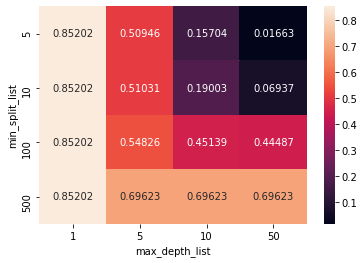


Heatmap for log_loss values CV data


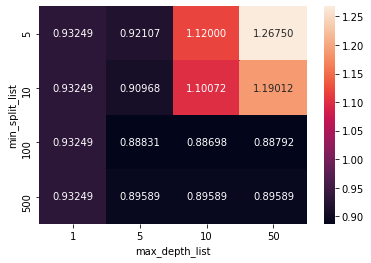


Best Values -Decision Tree

train mse for min_split= 100 and max_depth= 10  is 0.6962339798968734
cv mse for min_split= 100 and max_depth= 10  is 0.8958890399957383
/nHyper Parameter Tuning for Decision Tree:
Heatmap for log_loss values Train data


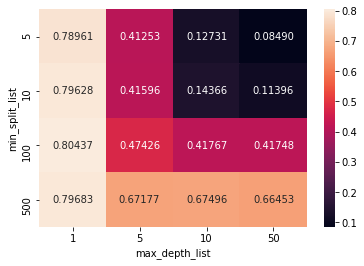


Heatmap for log_loss values CV data


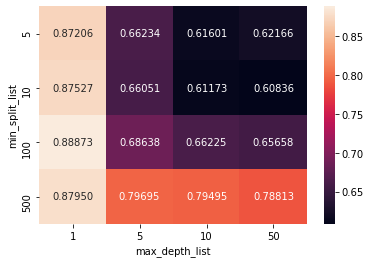


Best Values -RandomForestRegressor:

train mse for min_split= 10 and max_depth= 50  is 0.6645278638353967
cv mse for min_split= 10 and max_depth= 50  is 0.7881278424099389
/nHyper Parameter Tuning for Light_gbm:
cv mse for C= 10 is 0.8535743858466647
cv mse for C= 50 is 0.7474773550722994
cv mse for C= 100 is 0.7411391673278687
cv mse for C= 350 is 0.741558242686833
cv mse for C= 400 is 0.7416227364339801
cv mse for C= 500 is 0.741613885434853

Best Values -Light_gbm

train mse for estimators= 100 is 0.12493225465506311
cv mse for estimators= 100 is 0.7411391673278687
/nHyper Parameter Tuning for CatBoost:
cv mse for iterations= 10 is 0.838043147346953
cv mse for iterations= 50 is 0.7654744439896427
cv mse for iterations= 100 is 0.7499423833396061
cv mse for iterations= 250 is 0.7519607533476003
cv mse for iterations= 500 is 0.7510246330639901

Best Values -CatBoost

train mse for C= 100 is 0.016051899695112278
cv mse for iterations= 100 is 0.7510246330639901


In [16]:
clf_xg_avgw2v,mse_tr_xg_avgw2v,mse_cv_xg_avgw2v=xgboost(x_train,y_train,x_cv,y_cv)

clf_lr_avgw2v,mse_tr_lr_avgw2v,mse_cv_lr_avgw2v=linear_regression(x_train,y_train,x_cv,y_cv)

clf_knn_avgw2v,mse_tr_knn_avgw2v,mse_cv_knn_avgw2v=knn_regression(x_train,y_train,x_cv,y_cv)

clf_svrlr_avgw2v,mse_tr_svrlr_avgw2v,mse_cv_svrlr_avgw2v=SVR_Linear(x_train,y_train,x_cv,y_cv)

clf_svrrbf_avgw2v,mse_tr_svrrbf_avgw2v,mse_cv_svrrbf_avgw2v=SVR_rbf(x_train,y_train,x_cv,y_cv)

clf_svrsig_avgw2v,mse_tr_svrsig_avgw2v,mse_cv_svrsig_avgw2v=SVR_sigmoid(x_train,y_train,x_cv,y_cv)

clf_dt_avgw2v,mse_tr_dt_avgw2v,mse_cv_dt_avgw2v=Decision_Tree(x_train,y_train,x_cv,y_cv)

clf_rf_avgw2v,mse_tr_rf_avgw2v,mse_cv_rf_avgw2v=Random_Forest(x_train,y_train,x_cv,y_cv)

clf_lgbm_avgw2v,mse_tr_lgbm_avgw2v,mse_cv_lgbm_avgw2v=Light_gbm(x_train,y_train,x_cv,y_cv)

clf_cb_avgw2v,mse_tr_cb_avgw2v,mse_cv_cb_avgw2v=CatBoost(x_train,y_train,x_cv,y_cv)



clf_nn_avgw2v,mse_tr_nn_avgw2v,mse_cv_nn_avgw2v=neural_network(x_train,y_train,x_cv,y_cv)


In [17]:
from prettytable import PrettyTable
pt = PrettyTable()

pt.field_names = ["Models","Train MSE", " CV MSE"]
pt.add_row(["Linear Regression",  mse_tr_lr_avgw2v,mse_cv_lr_avgw2v])
pt.add_row(["KNN Regression",  mse_tr_knn_avgw2v,mse_cv_knn_avgw2v])
pt.add_row(["SVR Linear",  mse_tr_svrlr_avgw2v,mse_cv_svrlr_avgw2v])
pt.add_row(["SVR RBF",  mse_tr_svrrbf_avgw2v,mse_cv_svrrbf_avgw2v])
pt.add_row(["SVR Sigmoid",  mse_tr_svrsig_avgw2v,mse_cv_svrsig_avgw2v])
pt.add_row(["Decision Tree",   mse_tr_dt_avgw2v,mse_cv_dt_avgw2v])
pt.add_row(["Random Forest Classifier",  mse_tr_rf_avgw2v,mse_cv_rf_avgw2v ])
pt.add_row(["LGBM Classifier",  mse_tr_lgbm_avgw2v,mse_cv_lgbm_avgw2v])
pt.add_row(["XGBoost", mse_tr_xg_avgw2v,mse_cv_xg_avgw2v])
pt.add_row(["CatBoost", mse_tr_cb_avgw2v,mse_cv_cb_avgw2v])
pt.add_row(["Neural Network", mse_tr_nn_avgw2v,mse_cv_nn_avgw2v])
print(pt)

+--------------------------+----------------------+--------------------+
|          Models          |      Train MSE       |       CV MSE       |
+--------------------------+----------------------+--------------------+
|    Linear Regression     |  0.6122407286100171  | 0.7547965982798054 |
|      KNN Regression      |  0.7136954140397963  | 0.7701349330876363 |
|        SVR Linear        |  0.636218828248658   | 0.727533989137428  |
|         SVR RBF          |  0.5656506153573266  | 0.7143952253903351 |
|       SVR Sigmoid        |  0.8345266662619267  | 0.8676383805239382 |
|      Decision Tree       |  0.6962339798968734  | 0.8958890399957383 |
| Random Forest Classifier |  0.6645278638353967  | 0.7881278424099389 |
|     LGBM Classifier      | 0.12493225465506311  | 0.7411391673278687 |
|         XGBoost          |  0.2476599622773958  | 0.7497899135509848 |
|         CatBoost         | 0.016051899695112278 | 0.7510246330639901 |
|      Neural Network      |  0.4654960662605142  |

In [18]:
#Using the Best Models

#**SVR RBG
#**CatBoost
#**neural_network

x_tt=pd.DataFrame(x_test)
y_tt=pd.DataFrame(y_test)

model_list=clf_nn_avgw2v
y_test_nn=np.zeros((x_tt.shape[0],1))
for i in range(20):
  y_test_nn=y_test_nn+model_list[i].predict(x_tt)
y_test_nn=y_test_nn/20
y_test_nn1=y_test_nn.reshape(-1)

y_test_svrrbf=clf_svrrbf_avgw2v.predict(x_test)
y_test_cb=clf_cb_avgw2v.predict(x_test)

In [19]:
w1=0.4
w2=0.2
w3=0.4

y_pred=w1*y_test_svrrbf +w2*y_test_cb +w3*y_test_nn1
MSE_AVG_W2V=mean_squared_error(y_pred,y_test)
print('Applying AVGW2V test data mse:',mean_squared_error(y_pred,y_test))

Applying AVGW2V test data mse: 0.458675728286796


#Predicting Test data

In [20]:
#Using the Best Models


x_tt=pd.DataFrame(test_data_vect)


model_list=clf_nn_avgw2v
y_test_nn=np.zeros((x_tt.shape[0],1))

for i in range(20):
  y_test_nn=y_test_nn+model_list[i].predict(x_tt)
y_test_nn=y_test_nn/20
y_test_nn1=y_test_nn.reshape(-1)

y_test_svrrbf=clf_svrrbf_avgw2v.predict(test_data_vect)
y_test_cb=clf_cb_avgw2v.predict(test_data_vect)

In [21]:
w1=0.4
w2=0.2
w3=0.4

y_pred=w1*y_test_svrrbf +w2*y_test_cb +w3*y_test_nn1
#MSE_AVG_W2V=mean_squared_error(y_pred,y_test)
#print('Applying AVGW2V test data mse:',mean_squared_error(y_pred,y_test))

In [22]:
test_dat = pd.read_csv('/content/drive/MyDrive/CS2/test.csv',index_col='id')
y_pred_pd=pd.DataFrame(y_pred,index=test_dat.index,columns=['target'])
#y_pred_pd

#saving test data predicted
y_pred_pd.to_csv('./submission.csv')

In [24]:
#LeaderBoard

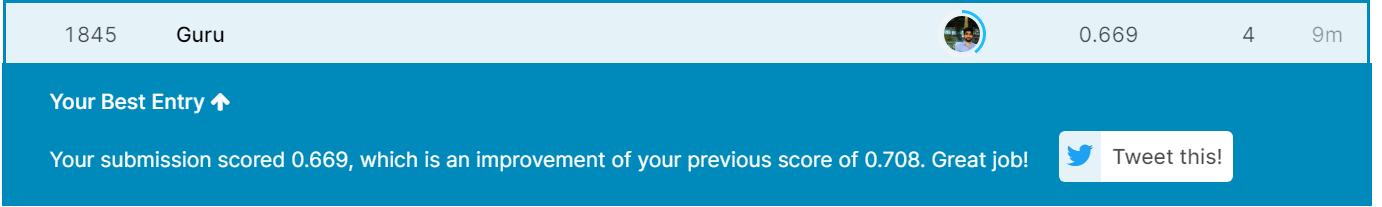